### Neurolib Attempt

In [184]:
%load_ext autoreload
%autoreload 2

from Jansen_Rit_Neurolib_Model import UniformlyDistributedNoise, JansenRitNode, SingleJansenRitMass, JansenRitNetwork
import matplotlib.pyplot as plt
import numpy as np
import symengine as se
from IPython.display import display
from jitcdde import input as system_input
from neurolib.models.multimodel import MultiModel, ThalamicNode
from neurolib.models.multimodel.builder.base.constants import LAMBDA_SPEED
from neurolib.models.multimodel.builder.base.network import Network, Node
from neurolib.models.multimodel.builder.base.neural_mass import NeuralMass
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.stimulus import Input, OrnsteinUhlenbeckProcess, StepInput
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func
from neurolib.models.wc import WCModel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# First we load the structural data set from the Human Connectome Project 
ds = Dataset("hcp")

In [278]:
#odel.params['duration'] = 3000

'''
model.params['exc_ext_baseline'] = 0.5 # Subcortical input level to each neural mass is 500 spikes / s
model.params['inh_ext_baseline'] = 0.5

model.params['dt'] = 2 # ms 2ms from paper
model.params['signalV'] = 2.0 # time delay for coupling

model.params['duration'] = 20 * 1000 # 20 seconds
model.params['sigma_ou'] = 1 # Noise Intensity = 1

model.params['c_excinh'] = 32 # Connection strength between main population of excitatory neurons and inhibitory neurons
model.params['c_inhexc'] = 3 # Connection strength between inhibitory neurons and main population of excitatory neurons

model.params['K_gl'] = 1 # Gain factor between neural masses 

model.params['mu_exc'] = 7 
model.params['mu_inh'] = 7 

print(model.params['dt'])
'''


model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['exc_ext'] = 0.65
#model.params['dt'] = 2 # ms 2ms from paper
model.params['signalV'] = 0
model.params['duration'] = 20 * 1000 
model.params['sigma_ou'] = 0.14
model.params['K_gl'] = 3.15
model.params['sampling_dt'] = 2

print(model.params['chunksize'])

KeyError: 'chunksize'

In [279]:
model.run(chunkwise=True)

(0.0, 200.0)

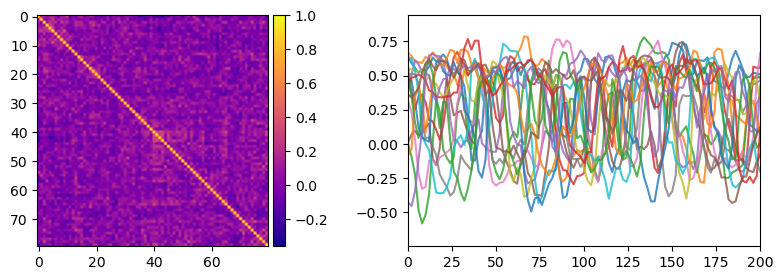

In [280]:
# a nice color map
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fc = func.fc(model.exc[:, -model.exc.shape[1]//2:])
im = axs[0].imshow(fc, cmap='plasma')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)

axs[1].plot(model.t, model.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)


In [269]:
print(model.exc.shape)
print(model.params['dt'])

(80, 10000)
0.1


In [265]:
from mne_connectivity import spectral_connectivity_epochs
X = model.exc
print(X.shape)
X = np.reshape(X, (5, X.shape[0], 200), order='C')
print(X.shape)

(80, 1000)
(5, 80, 200)


In [266]:
conn = spectral_connectivity_epochs(
	X,
	method="dpli",
	sfreq=250,
    fmin=8,
    fmax=30,
	verbose=False,
    faverage=True
)

ValueError: operands could not be broadcast together with shapes (80,80,221) (221,80,80) 

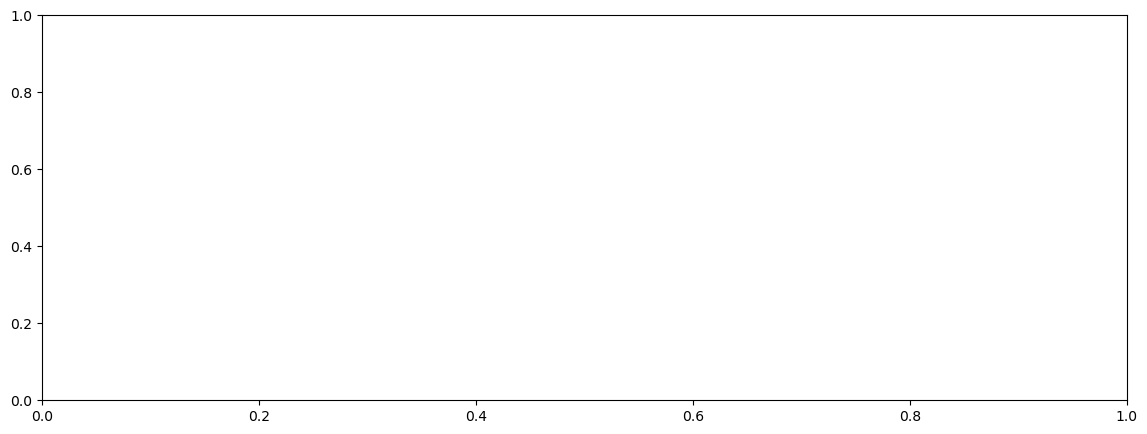

In [258]:
fig, axs = plt.subplots(1, 1, figsize=(14, 5), sharey=True)
axs.imshow(symmetrize(conn.get_data("dense")), vmin=0, vmax=1)
axs.set_title("dPLI")

In [229]:
def symmetrize(a):
    return a + a.T - np.diag(np.diag(a))

data = symmetrize(conn.get_data("dense")[:, :, 0])

avg = data.mean(axis=1)
print(avg.shape)

(80,)


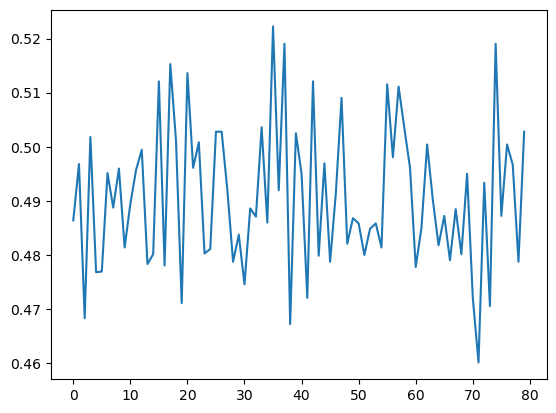

In [182]:
plt.plot(avg)

Done with 10, 30, 0.00858755859375, 0.45906250000000004
Done with 50, 30, 0.02846421875, 0.27875
Done with 100.0, 30, 0.010045058593749996, 0.15843749999999998
Done with 1000.0, 30, 0.0010243124999999998, 0.10725
Done with 10000.0, 30, 0.00108012109375, 0.0989375


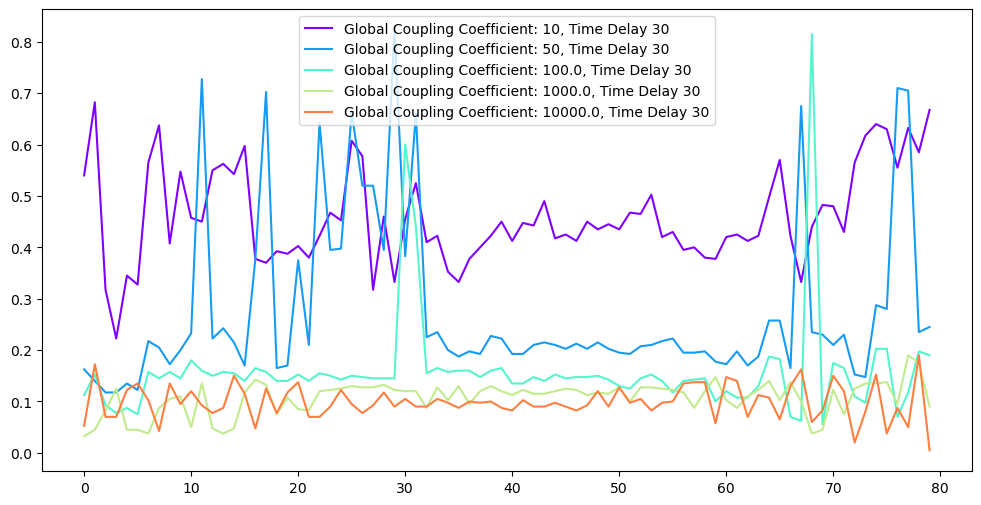

In [286]:
color = cm.rainbow(np.linspace(0, 1, 25))
plt.subplots(figsize=(12, 6))
for i, k_gl in enumerate([10, 50, 1e2, 1e3, 1e4]):
    #for j, signalV in enumerate([0, 5, 10, 20, 30]):
    for j, signalV in enumerate([30]):
        model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
        model.params['signalV'] = signalV
        model.params['K_gl'] = k_gl
        model.params['duration'] = 1 * 1000 
        
        trials = []
        for trial in range(5):
            model.run(chunkwise=True, chunksize=10000)
            X = model.exc
            trials.append(X)
        X = np.array(trials)

        conn = spectral_connectivity_epochs(
            X,
            method="dpli",
            sfreq=1000,
            fmin=8,
            fmax=30,
            verbose=False,
        )

        data = symmetrize(conn.get_data("dense")[:, :, 0])
        avg = data.mean(axis=1)
        if np.any(avg > 0.65) or np.any(avg < 0.35):
            plt.plot(avg, label=f"Global Coupling Coefficient: {k_gl}, Time Delay {signalV}", c = color[i*5 + j])
            print(f"Done with {k_gl}, {signalV}, {avg.var()}, {avg.mean()}")
plt.legend()
plt.show()

Done with 100.0, 100.0, 0.011124183593750003, 0.1476875
Done with 100.0, 1000.0, 0.01072968359375, 0.14381249999999998
Done with 100.0, 10000.0, 0.010861015624999996, 0.143125
Done with 100.0, 100000.0, 0.011013246093750003, 0.1420625
Done with 100.0, 1000000.0, 0.011042964843750001, 0.1400625
Done with 1000.0, 100.0, 0.0009604062499999997, 0.10525
Done with 1000.0, 1000.0, 0.0009105624999999997, 0.10225
Done with 1000.0, 10000.0, 0.0010245312499999998, 0.10375000000000001
Done with 1000.0, 100000.0, 0.00091840234375, 0.10606249999999999
Done with 1000.0, 1000000.0, 0.0010633398437499997, 0.0984375


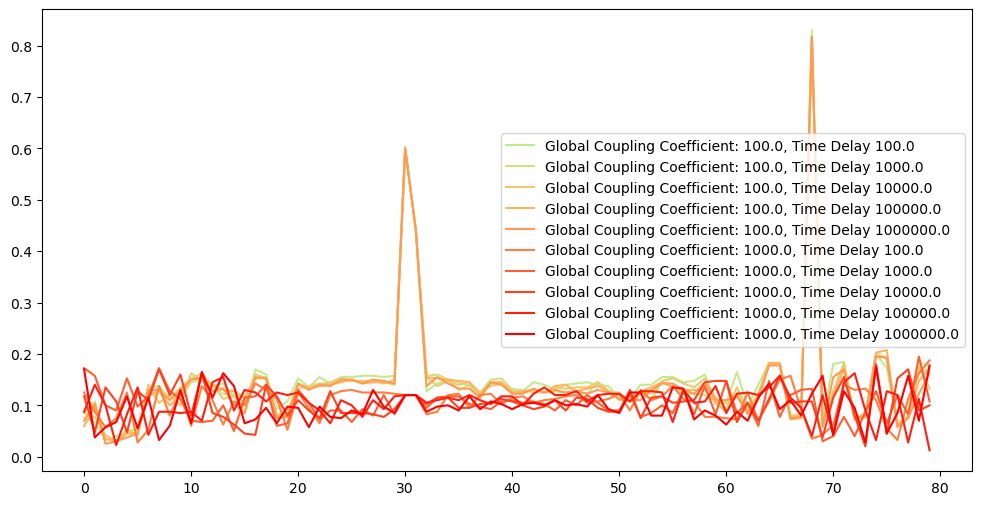

In [284]:
color = cm.rainbow(np.linspace(0, 1, 25))
plt.subplots(figsize=(12, 6))
for i, k_gl in enumerate([1e-3, 1e-2, 1e-1, 1e2, 1e3]):
    #for j, signalV in enumerate([0, 5, 10, 20, 30]):
    for j, signalV in enumerate([1e2, 1e3, 1e4, 1e5, 1e6]):
        model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
        model.params['signalV'] = signalV
        model.params['K_gl'] = k_gl
        model.params['duration'] = 1 * 1000 
        
        trials = []
        for trial in range(5):
            model.run(chunkwise=True, chunksize=10000)
            X = model.exc
            trials.append(X)
        X = np.array(trials)

        conn = spectral_connectivity_epochs(
            X,
            method="dpli",
            sfreq=1000,
            fmin=8,
            fmax=30,
            verbose=False,
        )

        data = symmetrize(conn.get_data("dense")[:, :, 0])
        avg = data.mean(axis=1)
        if np.any(avg > 0.65) or np.any(avg < 0.35):
            plt.plot(avg, label=f"Global Coupling Coefficient: {k_gl}, Time Delay {signalV}", c = color[i*5 + j])
            print(f"Done with {k_gl}, {signalV}, {avg.var()}, {avg.mean()}")
plt.legend()
plt.show()